# Energy distributions: series expansion and resolvent

Each initial state $\ket{\psi}$ can be evaluated through its associated energy distribution -- a continuous function roughly corresponding to the projection of the initial state onto the exact eigenstates of the Hamiltonian.

In this notebook, we show how to calculate the energy distribution of a model system and the Hartree-Fock state using two approaches: a) series expansion (Gram-Charlier or Edgeworth), and b) resolvent method.

#### Create the system

Start by creating a PySCF `Molecule` and running an RHF calculation on it

In [2]:
import numpy as np
from pyscf import gto

from overlapper.state import do_hf, hf_state

############### define a system of interest ##############
hftype = "rhf" 
R = 2.5
N = 4
mol = gto.M(atom=[['H', (0, 0, i * R)] for i in range(N)], basis='sto6g', symmetry="d2h")

# run  HF calculation
hf, hf_e, hf_ss, hf_sz = do_hf(mol, hftype)
wf_hf = hf_state(hf)
print(f"HF wavefunction: \n {wf_hf}")
print(f"\nRHF energy: {hf_e[0]:.3f}")
print(f"\nRHF S^2 and Sz: {hf_ss[0]:.3f}, {hf_sz[0]:.3f}")

HF wavefunction: 
 {(3, 3): 1.0}

RHF energy: -1.428

RHF S^2 and Sz: 0.000, 0.000


Once the system and state of interest (the Hartree-Fock state) are generated, we can study the energy distribution of that state.

## **Series expansion methods for energy distribution**

Series expansion methods work by reconstructing the probability density $P(E)dE$ by using the Hamiltonian moments $\langle \psi | H^n | \psi \rangle$ of the initial state $|\psi\rangle$. Gram-Charlier and Edgeworth are two different re-summations of the same series. 

As the first step, we use Overlapper to generate the moments associated with our trial state, the Hartree-Fock state. In this case we will use the DMRG approach to get the moments. We then employ those moments to compute an approximation to the energy distribution.

In [3]:
from overlapper.state import do_dmrg, dmrg_state
from overlapper.moments import rfci_moments, dmrg_moments
from overlapper.edist import gram_charlier_series, edgeworth_series

energies = np.linspace(-4., 0., 200)
eta = 0.1

# obtain moments using the DMRG approach
kmax = 2
bra_bond_dims = [500,1000]
bond_dims = [1]
n_sweeps = [20]
noises = [1e-6]
thrds = [1e-5]
sch = [bond_dims, n_sweeps, noises, thrds]
ncas, nelecas = 4, (2,2)
eshift = - mol.energy_nuc()
mpo, mps, driver = do_dmrg(hf, ncas, nelecas, sch, eshift=eshift, \
                                        mpssym="su2", return_objects=True)
hf_moments = dmrg_moments(driver, mps, mpo, bra_bond_dims, kmax, verbose=0)

# get Gram-Charlier approximation
gc_vals = gram_charlier_series(kmax, energies, [0] + list(hf_moments))

# get Edgeworth approximation
edgeworth_vals = edgeworth_series(kmax, energies, [0] + list(hf_moments))

### Exact distribution

To benchmark the approximate energy distributions against exact results, we can also compute the precise energy distribution using Overlapper.

In [4]:
from overlapper.edist import energy_pdf

# get state PDF
nstates = 20
hf_pdf, exact_gs = energy_pdf(mol, hftype, wf_hf, eta=eta, nroots=nstates, verbose=0)
hf_pdf_vals = np.array([ hf_pdf(e) for e in energies ])

Exact ground-state overlap^2: 0.3302748745354293

Total projected weight of the wavefunction: 1.000.

Energy of the state from the energy distribution: -2.3452961289611443.


The plot of Edgeworth and Gram-Charlier approximations against the exact distribution shows that they serve as adequate approximations of the energy distribution in this case.

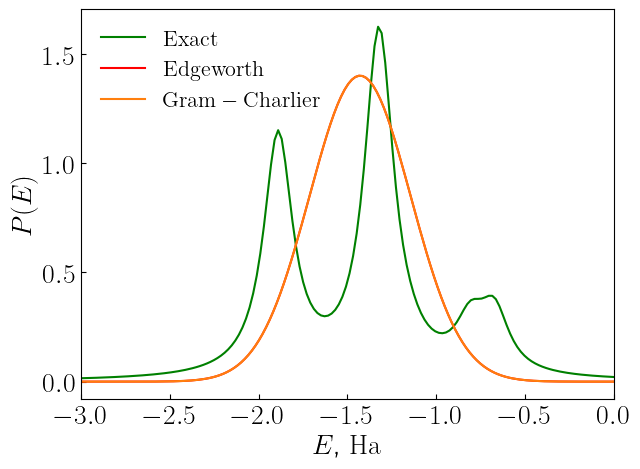

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True

# plot these
fig, ax = plt.subplots()
ax.plot(energies, hf_pdf_vals, color='g', label = r'$\mathrm{Exact}$')
ax.plot(energies+mol.energy_nuc(), edgeworth_vals, color='r', label = r'$\mathrm{Edgeworth}$')
ax.plot(energies+mol.energy_nuc(), gc_vals, color='tab:orange', label = r'$\mathrm{Gram-Charlier}$')
ax.legend(fontsize=16, frameon=False)
ax.tick_params(axis="both", direction="in", labelsize=20)
ax.set_xlabel(r"$E$, $\mathrm{Ha}$", size=20)
ax.set_ylabel(r"$P(E)$", size=20)
ax.set_xlim(-3,0)
plt.tight_layout()
plt.show()

However, the series expansion method can be unstable for approximating the energy distribution -- especially in systems with large gaps in the spectrum.

## **Energy distribution with the resolvent method**

The second method of approximating the energy distribution is through the resolvent method. Thanks to recent updates in Block2, it is straightforward to re-purpose Block2 Driver functionality to run a resolvent method calculation.

### Set up parallel resolvent calculations: MPI

As mentioned in earlier notebooks, the `do_dmrg()` method is special in Overlapper, because DMRG structures are exploited beyond just obtaining an initial state -- for example, for the resolvent method. 

For this purpose, passing `return_objects = True` returns, instead of the usual initial state, internal runtime objects such as `DMRGDriver`, `mps` of the state and `mpo` of the Hamiltonian.

In order to speedup the calculation, we will do it using MPI via Python-based `mpi4py`. This assumes you have an installed MPI implementation with proper links to `mpi4py`: guides for this are available elsewhere.

To run the code below using multiple processes, re-start this kernel with 

```ipcluster start -n 4 --engines=MPIEngineSetLauncher```

If you prefer to run it serially, just comment out the `mpi4py` lines.

In [6]:
from mpi4py import MPI 
# set up MPI
COMM = MPI.COMM_WORLD
worldsize = COMM.Get_size()
rank = COMM.Get_rank()

We already have a `driver`, `mpo` and `mps` from the calculation of the moments: let us re-use those, and jump straight into energy distribution calculation.

In [7]:
edist = []
gf_tol = 1e-3 # tolerance of the energy distribution convergence with sweeps in DMRG
gf_thrds = [1e-4] # tolerance of internal linear equation solver at each site  

Partition the jobs among the MPI ranks with Overlapper subroutines and execute a helper Overlapper function to run the resolvent method. To ensure roughly equal loads, the list of energy points is randomized, then partitioned as equally among the ranks as possible.

In [8]:
from overlapper.utils.utils import jobs_on_rank
from overlapper.edist import resolvent_calc
import time
shuffled_jobs = jobs_on_rank(energies, worldsize, rank)

start = time.time()
rank_results = [resolvent_calc(driver, mps, mpo, \
                freq, eta, rank=rank) for freq in shuffled_jobs]
COMM.Barrier()
dt = time.time() - start

rank = 0 doing omega = -0.040 result = -0.445-0.021j took 0.03 seconds
rank = 0 doing omega = -1.809 result = -0.826-0.829j took 0.03 seconds
rank = 0 doing omega = -1.970 result = -1.637-0.843j took 0.02 seconds
rank = 0 doing omega = -1.487 result = -1.581-0.621j took 0.02 seconds
rank = 0 doing omega = -3.035 result = 1.998-0.641j took 0.02 seconds
rank = 0 doing omega = -0.060 result = -0.450-0.021j took 0.02 seconds
rank = 0 doing omega = -3.417 result = 1.057-0.130j took 0.02 seconds
rank = 0 doing omega = -0.181 result = -0.479-0.024j took 0.02 seconds
rank = 0 doing omega = -0.804 result = -0.698-0.054j took 0.02 seconds
rank = 0 doing omega = -1.146 result = -0.958-0.115j took 0.02 seconds
rank = 0 doing omega = -2.553 result = 0.434-0.942j took 0.03 seconds
rank = 0 doing omega = -2.171 result = -2.520-3.600j took 0.04 seconds
rank = 0 doing omega = -3.719 result = 0.787-0.068j took 0.02 seconds
rank = 0 doing omega = -3.497 result = 0.972-0.107j took 0.02 seconds
rank = 0 do

Once the calculation is done, collect the results on the head process

In [9]:
# Gather the results on rank 0
all_jobs = np.array(COMM.gather(shuffled_jobs, root=0), dtype=object)
gf = np.array(COMM.gather(rank_results, root=0), dtype=object)

Finally, restore proper order to the results from shuffling and post-process for visualization.

In [10]:
if rank == 0:
    print(f"Total time taken: {dt:.2f}")

    # re-shape ragged nesting lists from ranks together
    gf = np.array([item for list_from_rank in gf for item in list_from_rank])
    gf = gf.reshape(len(energies)) 
    # re-shape the ragged nesting lists from shuffled jobs array
    all_jobs = np.array([xx[ii] for xx in
                                all_jobs for ii in range(len(xx))])

    # get the indexing order for sorting the frequencies in the ascending order
    sorted_idx = np.argsort(all_jobs)
    # use the indexing to un-scramble the results 
    gf = gf[sorted_idx]
    edist = -gf.imag / np.pi
    mean = np.sum(edist * energies) / np.sum(edist)

Total time taken: 4.23


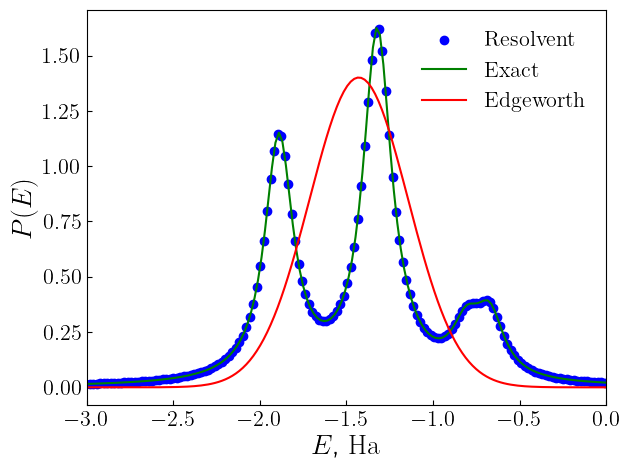

In [10]:
if rank == 0:
    import matplotlib.pyplot as plt
    plt.rcParams["text.usetex"] = True
    fig, ax = plt.subplots()
    ax.scatter(energies+mol.energy_nuc(), edist, color="b", label = r'$\mathrm{Resolvent}$')
    ax.plot(energies, hf_pdf_vals, color='g', label = r'$\mathrm{Exact}$')
    ax.plot(energies+mol.energy_nuc(), edgeworth_vals, color='r', label = r'$\mathrm{Edgeworth}$')
    ax.tick_params(axis="both", direction="in", labelsize=16)
    ax.set_xlabel(r"$E$, $\mathrm{Ha}$", size=20)
    ax.set_ylabel(r"$P(E)$", size=20)
    ax.set_xlim(-3,0)
    ax.legend(fontsize=16, frameon=False)
    plt.tight_layout()
    plt.show()

Unlike the series expansion method, the resolvent method always returns a positive-definite energy distribution, is generally more accurate, and can handle much larger systems.